##### Source: https://www.kaggle.com/code/reukki/pytorch-cnn-tutorial-with-cats-and-dogs/notebook

In [26]:
#about torch...
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

#using numpy
import numpy as np

#for data load or save
import pandas as pd

#visualize some datasets
import matplotlib.pyplot as plt

#check our work directory
import os

#to unzip datasets
import zipfile

In [31]:
lr = 0.001 # learning_rate
batch_size = 100 # we will use mini-batch method
epochs = 10 # How much to train a model

In [33]:


device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)



In [9]:
DIR_TRAIN = "data/DoagCatsImages/train/"
DIR_TEST = "data/DoagCatsImages/test1/"

In [8]:
! cd data/DoagCatsImages/train/ ; ls

cat.0.jpg      cat.3250.jpg  cat.7751.jpg   dog.12250.jpg  dog.5500.jpg
cat.10000.jpg  cat.3251.jpg  cat.7752.jpg   dog.12251.jpg  dog.5501.jpg
cat.10001.jpg  cat.3252.jpg  cat.7753.jpg   dog.12252.jpg  dog.5502.jpg
cat.10002.jpg  cat.3253.jpg  cat.7754.jpg   dog.12253.jpg  dog.5503.jpg
cat.10003.jpg  cat.3254.jpg  cat.7755.jpg   dog.12254.jpg  dog.5504.jpg
cat.10004.jpg  cat.3255.jpg  cat.7756.jpg   dog.12255.jpg  dog.5505.jpg
cat.10005.jpg  cat.3256.jpg  cat.7757.jpg   dog.12256.jpg  dog.5506.jpg
cat.10006.jpg  cat.3257.jpg  cat.7758.jpg   dog.12257.jpg  dog.5507.jpg
cat.10007.jpg  cat.3258.jpg  cat.7759.jpg   dog.12258.jpg  dog.5508.jpg
cat.10008.jpg  cat.3259.jpg  cat.775.jpg    dog.12259.jpg  dog.5509.jpg
cat.10009.jpg  cat.325.jpg   cat.7760.jpg   dog.1225.jpg   dog.550.jpg
cat.1000.jpg   cat.3260.jpg  cat.7761.jpg   dog.12260.jpg  dog.5510.jpg
cat.10010.jpg  cat.3261.jpg  cat.7762.jpg   dog.12261.jpg  dog.5511.jpg
cat.10011.jpg  cat.3262.jpg  cat.7763.jpg   dog.12262.jpg  dog.55

In [10]:
imgs = os.listdir(DIR_TRAIN) 
test_imgs = os.listdir(DIR_TEST)

print(imgs[:5])
print(test_imgs[:5])

['cat.9596.jpg', 'dog.11125.jpg', 'cat.10594.jpg', 'dog.4893.jpg', 'cat.2644.jpg']
['10806.jpg', '492.jpg', '5670.jpg', '3302.jpg', '5762.jpg']


In [19]:
import glob

train_list = glob.glob(os.path.join(DIR_TRAIN,'*.jpg'))
test_list = glob.glob(os.path.join(DIR_TRAIN, '*.jpg'))

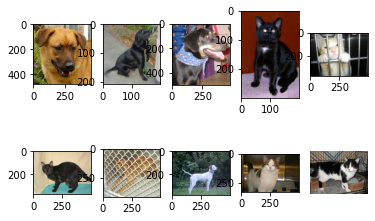

In [22]:
from PIL import Image
random_idx = np.random.randint(1,25000,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(train_list[idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

In [23]:
train_list[0].split('/')[-1].split('.')[0]

'cat'

In [24]:
print(len(train_list), len(test_list))

25000 25000


In [25]:


from sklearn.model_selection import train_test_split
train_list, val_list = train_test_split(train_list, test_size=0.2)



In [27]:
     

#data Augumentation
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])


test_transforms = transforms.Compose([   
    transforms.Resize((224, 224)),
     transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])



In [28]:
class dataset(torch.utils.data.Dataset):
    
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    #load an one of images
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0
            
        return img_transformed,label

In [29]:
train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=test_transforms)

In [32]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

In [34]:


print(len(train_data), len(train_loader))



20000 200


In [35]:


print(len(val_data), len(val_loader))



5000 50


In [42]:
#check our images shape
#check our images shape
train_data[0][0][0].shape

torch.Size([224, 224])


build Model

    3 Convolution layer and 2 fully connected layer
    batchNormalization for limit overfitting



In [43]:


class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out



In [44]:
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

### set Loss function and optimizer

In [45]:
optimizer = optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

### Train our Network

In [46]:
epochs = 10

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        
        output = model(data)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
        
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
    
    
    with torch.no_grad():
        epoch_val_accuracy=0
        epoch_val_loss =0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)
            
            val_output = model(data)
            val_loss = criterion(val_output,label)
            
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(val_loader)
            epoch_val_loss += val_loss/ len(val_loader)
            
        print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))

Epoch : 1, train accuracy : 0.6532001495361328, train loss : 0.6225034594535828
Epoch : 1, val_accuracy : 0.6890000104904175, val_loss : 0.5822911262512207
Epoch : 2, train accuracy : 0.7093002200126648, train loss : 0.5581439137458801
Epoch : 2, val_accuracy : 0.7095999717712402, val_loss : 0.5557860136032104
Epoch : 3, train accuracy : 0.7286502122879028, train loss : 0.5318625569343567
Epoch : 3, val_accuracy : 0.7371998429298401, val_loss : 0.527339518070221
Epoch : 4, train accuracy : 0.7454001307487488, train loss : 0.5133754014968872
Epoch : 4, val_accuracy : 0.740399956703186, val_loss : 0.5172643065452576
Epoch : 5, train accuracy : 0.7494000792503357, train loss : 0.4951024651527405
Epoch : 5, val_accuracy : 0.7594000101089478, val_loss : 0.5013179779052734
Epoch : 6, train accuracy : 0.7601500749588013, train loss : 0.48411551117897034
Epoch : 6, val_accuracy : 0.7626000046730042, val_loss : 0.49354806542396545
Epoch : 7, train accuracy : 0.767300009727478, train loss : 0.47

In [47]:
dog_probs = []
model.eval()
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        dog_probs += list(zip(list(fileid), preds_list))

In [50]:
dog_probs.sort(key = lambda x : int(x[0]))
dog_probs[:20]

[(tensor(0), 0.24033617973327637),
 (tensor(0), 0.04460909590125084),
 (tensor(0), 0.524486780166626),
 (tensor(0), 0.033858586102724075),
 (tensor(0), 0.2532992362976074),
 (tensor(0), 0.24130786955356598),
 (tensor(0), 0.03762703016400337),
 (tensor(0), 0.04624653607606888),
 (tensor(0), 0.5972294211387634),
 (tensor(0), 0.31721237301826477),
 (tensor(0), 0.030243972316384315),
 (tensor(0), 0.015980664640665054),
 (tensor(0), 0.15599796175956726),
 (tensor(0), 0.0775294154882431),
 (tensor(0), 0.2840074598789215),
 (tensor(0), 0.26961106061935425),
 (tensor(0), 0.06224554032087326),
 (tensor(0), 0.36908069252967834),
 (tensor(0), 0.11633913218975067),
 (tensor(0), 0.8745641112327576)]

In [51]:
idx = list(map(lambda x: x[0],dog_probs))
prob = list(map(lambda x: x[1],dog_probs))

In [52]:
submission = pd.DataFrame({'id':idx,'label':prob})

In [53]:
submission.head()

,id,label
0,tensor(0),0.240336
1,tensor(0),0.044609
2,tensor(0),0.524487
3,tensor(0),0.033859
4,tensor(0),0.253299


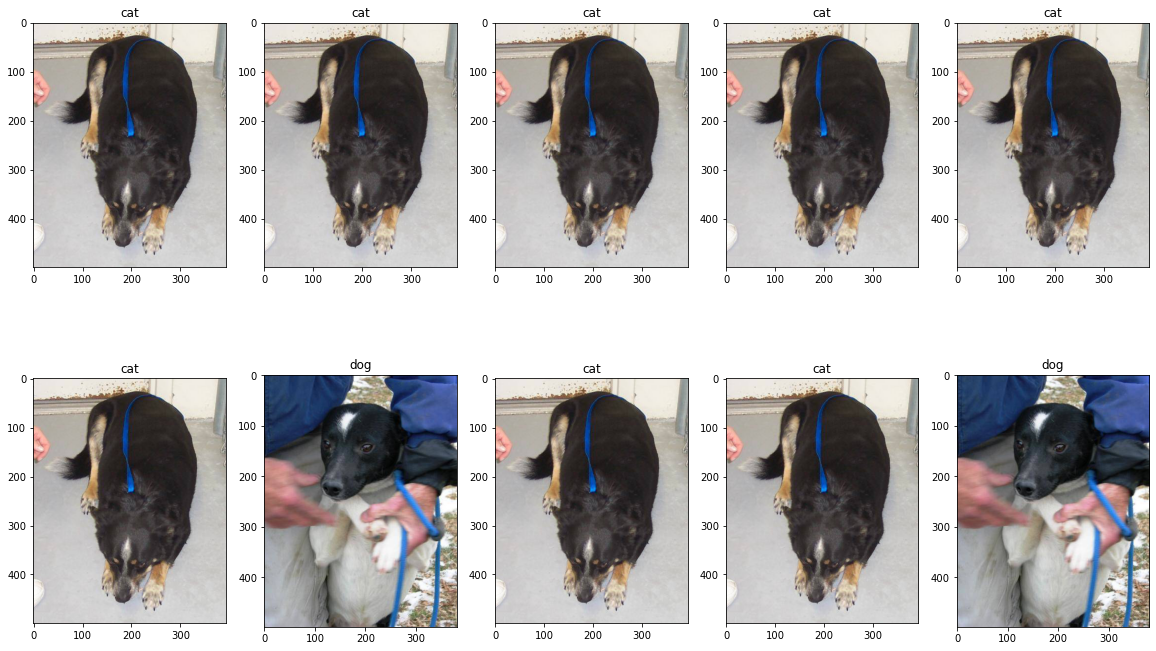

In [59]:
import random

id_list = []
class_ = {0: 'cat', 1: 'dog'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(DIR_TEST, '{}.jpg'.format(i))
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)